In [1]:
# %% 
import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from typing import List, Tuple

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cpu


In [2]:
# %%
class PolicyNetwork(nn.Module):
    def __init__(self, state_dim: int, hidden_sizes: List[int], action_dim: int):
        super().__init__()
        layers = []
        input_dim = state_dim
        for h in hidden_sizes:
            layers.append(nn.Linear(input_dim, h))
            layers.append(nn.ReLU())
            input_dim = h
        layers.append(nn.Linear(input_dim, action_dim))  # logits output
        self.net = nn.Sequential(*layers)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Return action logits for a batch of states."""
        return self.net(x)


class ValueNetwork(nn.Module):
    def __init__(self, state_dim: int, hidden_sizes: List[int]):
        super().__init__()
        layers = []
        input_dim = state_dim
        for h in hidden_sizes:
            layers.append(nn.Linear(input_dim, h))
            layers.append(nn.ReLU())
            input_dim = h
        layers.append(nn.Linear(input_dim, 1))  # scalar V(s)
        self.net = nn.Sequential(*layers)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Return scalar value estimates V(s)."""
        return self.net(x).squeeze(-1)


In [3]:
# %%
def set_seed(seed: int):
    np.random.seed(seed)
    torch.manual_seed(seed)
    try:
        torch.cuda.manual_seed_all(seed)
    except Exception:
        pass


def compute_returns(rewards: List[float], gamma: float) -> torch.Tensor:
    """Compute discounted returns G_t for each time step (as PyTorch tensor)."""
    G = 0.0
    returns = []
    for r in reversed(rewards):
        G = r + gamma * G
        returns.insert(0, G)
    return torch.tensor(returns, dtype=torch.float32, device=device)


def run_episode(env, policy: PolicyNetwork, gamma: float) -> Tuple[List[torch.Tensor],
                                                                   List[torch.Tensor],
                                                                   List[float]]:
    """Run one episode using the current policy.
    
    Returns lists of:
    - states (torch tensors)
    - log_probs (torch tensors)
    - rewards (floats)
    """
    state, _ = env.reset()
    done = False

    states: List[torch.Tensor] = []
    log_probs: List[torch.Tensor] = []
    rewards: List[float] = []

    while not done:
        state_tensor = torch.tensor(state, dtype=torch.float32, device=device)
        logits = policy(state_tensor)
        dist = torch.distributions.Categorical(logits=logits)
        action = dist.sample()
        log_prob = dist.log_prob(action)

        next_state, reward, terminated, truncated, _ = env.step(action.item())
        done = terminated or truncated

        states.append(state_tensor)
        log_probs.append(log_prob)
        rewards.append(float(reward))

        state = next_state

    return states, log_probs, rewards


In [4]:
# %%
def train_reinforce_single_seed(
    seed: int,
    num_episodes: int = 500,
    gamma: float = 0.99,
    lr_policy: float = 1e-3,
) -> List[float]:
    """Train REINFORCE (no baseline) for a single random seed."""
    set_seed(seed)
    env = gym.make("CartPole-v1")
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.n

    policy = PolicyNetwork(state_dim, hidden_sizes=[128, 128], action_dim=action_dim).to(device)
    optimizer = optim.Adam(policy.parameters(), lr=lr_policy)

    episode_returns: List[float] = []

    for episode in range(num_episodes):
        states, log_probs, rewards = run_episode(env, policy, gamma)
        returns = compute_returns(rewards, gamma)

        # Normalize returns for variance reduction
        returns = (returns - returns.mean()) / (returns.std() + 1e-8)

        log_probs_tensor = torch.stack(log_probs)
        policy_loss = -(log_probs_tensor * returns).sum()

        optimizer.zero_grad()
        policy_loss.backward()
        optimizer.step()

        total_return = sum(rewards)
        episode_returns.append(total_return)

        if (episode + 1) % 50 == 0:
            print(f"[REINFORCE] Seed {seed} Episode {episode+1}/{num_episodes} "
                  f"Return: {total_return:.1f}")

    env.close()
    return episode_returns


In [5]:
# %%
def train_reinforce_baseline_single_seed(
    seed: int,
    num_episodes: int = 500,
    gamma: float = 0.99,
    lr_policy: float = 1e-3,
    lr_value: float = 1e-3,
) -> Tuple[List[float], PolicyNetwork, ValueNetwork]:
    """Train REINFORCE with learned value baseline for a single seed.
    
    Returns:
    - list of episode returns
    - trained policy network
    - trained value network
    """
    set_seed(seed)
    env = gym.make("CartPole-v1")
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.n

    policy = PolicyNetwork(state_dim, hidden_sizes=[128, 128], action_dim=action_dim).to(device)
    value_net = ValueNetwork(state_dim, hidden_sizes=[128, 128]).to(device)

    policy_opt = optim.Adam(policy.parameters(), lr=lr_policy)
    value_opt = optim.Adam(value_net.parameters(), lr=lr_value)

    episode_returns: List[float] = []

    for episode in range(num_episodes):
        states, log_probs, rewards = run_episode(env, policy, gamma)
        returns = compute_returns(rewards, gamma)

        states_tensor = torch.stack(states)  # (T, state_dim)
        values = value_net(states_tensor)    # (T,)
        advantages = returns - values.detach()

        log_probs_tensor = torch.stack(log_probs)

        # Policy loss (maximize expected advantage)
        policy_loss = -(log_probs_tensor * advantages).sum()

        # Value loss (fit returns with MSE)
        value_loss = F.mse_loss(values, returns)

        policy_opt.zero_grad()
        value_opt.zero_grad()
        policy_loss.backward()
        value_loss.backward()
        policy_opt.step()
        value_opt.step()

        total_return = sum(rewards)
        episode_returns.append(total_return)

        if (episode + 1) % 50 == 0:
            print(f"[REINFORCE+Baseline] Seed {seed} Episode {episode+1}/{num_episodes} "
                  f"Return: {total_return:.1f}")

    env.close()
    return episode_returns, policy, value_net


In [ ]:
# %%
num_episodes = 500
gamma = 0.99
seeds = [0, 1, 2, 3, 4]        

all_returns_reinforce = []
all_returns_baseline = []

final_policy = None
final_value_net = None
final_seed = seeds[-1]

for seed in seeds:
    print(f"\n=== Training Seed {seed} (REINFORCE) ===")
    returns_r = train_reinforce_single_seed(
        seed, 
        num_episodes=num_episodes, 
        gamma=gamma
    )
    all_returns_reinforce.append(returns_r)

    print(f"\n=== Training Seed {seed} (REINFORCE + Baseline) ===")
    returns_b, policy_b, value_b = train_reinforce_baseline_single_seed(
        seed, 
        num_episodes=num_episodes, 
        gamma=gamma
    )
    all_returns_baseline.append(returns_b)

    final_policy = policy_b
    final_value_net = value_b

all_returns_reinforce = np.array(all_returns_reinforce)
all_returns_baseline = np.array(all_returns_baseline)



=== Training Seed 0 (REINFORCE) ===
[REINFORCE] Seed 0 Episode 50/300 Return: 39.0
[REINFORCE] Seed 0 Episode 100/300 Return: 154.0
[REINFORCE] Seed 0 Episode 150/300 Return: 167.0
[REINFORCE] Seed 0 Episode 200/300 Return: 143.0
[REINFORCE] Seed 0 Episode 250/300 Return: 146.0
[REINFORCE] Seed 0 Episode 300/300 Return: 500.0

=== Training Seed 0 (REINFORCE + Baseline) ===
[REINFORCE+Baseline] Seed 0 Episode 50/300 Return: 39.0
[REINFORCE+Baseline] Seed 0 Episode 100/300 Return: 83.0
[REINFORCE+Baseline] Seed 0 Episode 150/300 Return: 256.0
[REINFORCE+Baseline] Seed 0 Episode 200/300 Return: 500.0
[REINFORCE+Baseline] Seed 0 Episode 250/300 Return: 119.0
[REINFORCE+Baseline] Seed 0 Episode 300/300 Return: 96.0

=== Training Seed 1 (REINFORCE) ===
[REINFORCE] Seed 1 Episode 50/300 Return: 44.0
[REINFORCE] Seed 1 Episode 100/300 Return: 211.0
[REINFORCE] Seed 1 Episode 150/300 Return: 265.0
[REINFORCE] Seed 1 Episode 200/300 Return: 107.0
[REINFORCE] Seed 1 Episode 250/300 Return: 500.0

In [7]:
# %%
def compute_mean_and_ci(returns_matrix: np.ndarray):
    """returns_matrix: shape (num_seeds, num_episodes)"""
    means = returns_matrix.mean(axis=0)
    stds = returns_matrix.std(axis=0, ddof=1)
    n = returns_matrix.shape[0]
    sem = stds / np.sqrt(n)
    ci95 = 1.96 * sem
    return means, ci95

mean_r, ci_r = compute_mean_and_ci(all_returns_reinforce)
mean_b, ci_b = compute_mean_and_ci(all_returns_baseline)


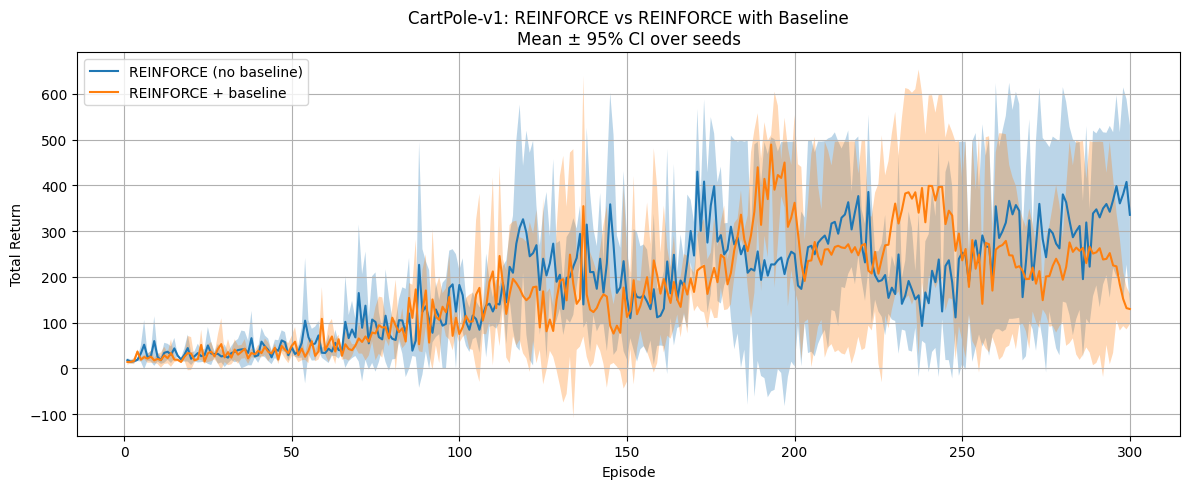

In [8]:
# %%
episodes = np.arange(1, num_episodes + 1)

plt.figure(figsize=(12, 5))

# REINFORCE
plt.plot(episodes, mean_r, label="REINFORCE (no baseline)")
plt.fill_between(episodes, mean_r - ci_r, mean_r + ci_r, alpha=0.3)

# REINFORCE + Baseline
plt.plot(episodes, mean_b, label="REINFORCE + baseline")
plt.fill_between(episodes, mean_b - ci_b, mean_b + ci_b, alpha=0.3)

plt.xlabel("Episode")
plt.ylabel("Total Return")
plt.title("CartPole-v1: REINFORCE vs REINFORCE with Baseline\nMean ± 95% CI over seeds")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [9]:
# %%
checkpoint_policy_path = f"cartpole_policy_reinforce_baseline_seed{final_seed}.pth"
checkpoint_value_path = f"cartpole_value_baseline_seed{final_seed}.pth"

torch.save(final_policy.state_dict(), checkpoint_policy_path)
torch.save(final_value_net.state_dict(), checkpoint_value_path)

print("Saved policy to:", checkpoint_policy_path)
print("Saved value network to:", checkpoint_value_path)


Saved policy to: cartpole_policy_reinforce_baseline_seed2.pth
Saved value network to: cartpole_value_baseline_seed2.pth
